
# Домашнее задание №3
## **Применение алгоритмов Random Forest и Gradient Boosting для классификации**
#### Выполнил: Артамонов Д., МАГ ИАД 2020
https://www.kaggle.com/gauravdesurkar/lt-vehicle-loan-default-prediction

Обучить на ваших данных 1) random forests, 2) gradient boosted trees. Постройте графики зависимости ошибки (на тестовой и обучающейся выборках, а также oob-ошибку) от количества используемых деревьев. Наблюдается ли переобучение/недообучение? Найдите значимости признаков. Сделайте выводы. Сделайте общие выводы по всем лабам. Какой метод оказался лучшим?

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score
from tqdm import tqdm
from collections import OrderedDict

from torch.utils.data import DataLoader
import torch
import os
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def dump(d, name):
    with open(name, 'wb') as handle:
        pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
def pickle_load(name):
    with open(name, 'rb') as p:
        obj = pickle.load(p)
    return obj

In [36]:
def merge_and_order(d1,d2):
    d = {**d1, **d2}
    accuracy_train_dict = OrderedDict(sorted(d.items()))
    return accuracy_train_dict

Вспомним как выглядят наши данные

In [6]:
data_path = 'VehicleLoanDefaultPrediction'
data = pd.read_csv(os.path.join(data_path, 'train.csv'))

In [142]:
data.head(5)

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


Воспользуемся  написанным классом Pytorch Loan Dataset для работы с данными

In [4]:
import loan_dataset

In [7]:
dataset = loan_dataset.VehicleLoanDataset(os.path.join(data_path, 'train.csv'), balance=True, mode='train', test_size=0.2)

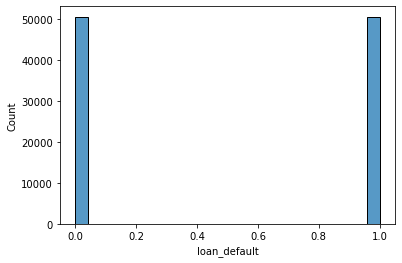

In [8]:
sns.histplot(dataset.data, x="loan_default")
plt.show()

In [8]:
print(f'Размер тренировочной выборки: {dataset.X_train.shape}\nразмер тестовой выборки: {dataset.X_test.shape}')

Размер тренировочной выборки: (80977, 35)
размер тестовой выборки: (20245, 35)


In [9]:
X_train, y_train = dataset.X_train, dataset.y_train.reshape(-1,)
X_test, y_test = dataset.X_test, dataset.y_test.reshape(-1,)

In [10]:
features = dataset.data.columns

## Random Forest

In [11]:
from sklearn import ensemble

In [83]:
rf_model = ensemble.RandomForestClassifier(n_estimators = 100,  oob_score=True)
rf_model.fit(X_train, y_train)

RandomForestClassifier(oob_score=True)

In [84]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [85]:
print(np.mean(y_train_pred != y_train))
print(np.mean(y_test_pred != y_test))

0.00023463452585301999
0.4087428994813534


In [86]:
print(np.mean(y_train_pred == y_train))
print(np.mean(y_test_pred == y_test))

0.999765365474147
0.5912571005186466


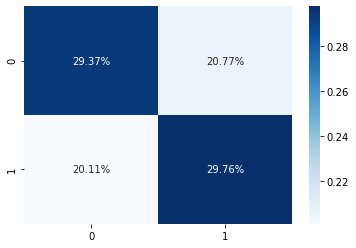

In [89]:
CF = confusion_matrix(y_test_pred, y_test)
sns.heatmap(CF/np.sum(CF), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

На обучающей выборке точность почти 100%, то есть модель переобучилась под тренировочную выборку. 

Конфигурация случайного леса [по умолчанию](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  не ограничивает глубину деревьев, то есть каждое дерево может быть очень глубоким и обучаться под конкретную выборку

### Зависимость ошибки от числа деревьев

Обучим несколько моделей с различным числом деревьев в лесу

In [63]:
accuracy_train_dict = {}
accuracy_test_dict = {}
oob_score_dict = {}
accuracy_train_dict2 = {}
accuracy_test_dict2 = {}
oob_score_dict2 = {}

Будем итерироваться от 5 до 500 деревьев с шагом 20 и от 5 до 100 с шагом 5

In [ ]:
for n_estimators in tqdm(range(5,500,20)):
    rf_model = ensemble.RandomForestClassifier(n_estimators=n_estimators,  oob_score=True)
    rf_model.fit(X_train, y_train)
    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)
    
    accuracy_train_dict[n_estimators] = accuracy_score(y_train_pred, y_train)
    accuracy_test_dict[n_estimators] = accuracy_score(y_test_pred, y_test)
    oob_score_dict[n_estimators] = rf_model.oob_score_
    

In [53]:
accuracy_train_dict = merge_and_order(accuracy_train_dict2, accuracy_train_dict)
accuracy_test_dict = merge_and_order(accuracy_test_dict2, accuracy_test_dict)
oob_score_dict = merge_and_order(oob_score_dict2, oob_score_dict)

Все результаты засунем в DataFrame

In [73]:
n_estimators_experiment = pd.DataFrame.from_dict(accuracy_train_dict, orient='index', columns=['accuracy_train'])
n_estimators_experiment['accuracy_test'] = accuracy_test_dict.values()
n_estimators_experiment['oob_score'] = oob_score_dict.values()
n_estimators_experiment.to_csv('n_estimators_experiment.csv')

In [80]:
n_estimators_experiment.head()

,accuracy_train,accuracy_test,oob_score
5,0.954580,0.554013,0.533596
10,0.984020,0.556829,0.544550
15,0.994900,0.571005,0.553182
20,0.997691,0.576389,0.559591
25,0.998839,0.578266,0.565605


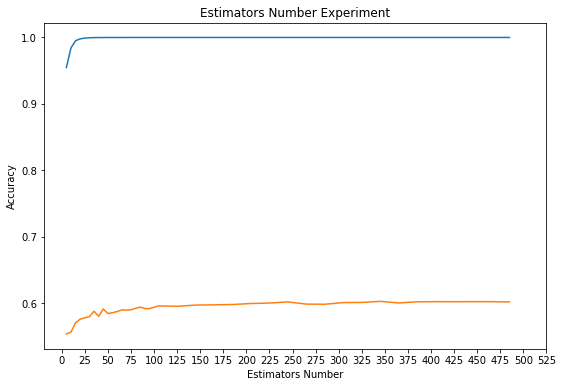

In [129]:
plt.figure(figsize=(9,6))
plt.title('Estimators Number Experiment')
plt.plot(n_estimators_experiment.index,n_estimators_experiment['accuracy_train'])
plt.plot(n_estimators_experiment.index,n_estimators_experiment['accuracy_test'])
plt.xlabel('Estimators Number')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,550,25))
plt.show()

In [113]:
n_estimators_experiment.max()

accuracy_train    0.999778
accuracy_test     0.603062
oob_score         0.597688
dtype: float64

In [114]:
n_estimators_experiment.min()

accuracy_train    0.954580
accuracy_test     0.554013
oob_score         0.533596
dtype: float64

Видно, что точность на тренировочном множестве достигает своего максимума при малом числе деревьев (меньше 50). 
Точность не тесте продолжает увеличиваться с ростом числа деревьев. Однако после 250 деревьев виден небольшой спад в точности, который свидетельствует о переобучении. С другой стороны, при числе деревьев от 25 до 50 видны пики, но они не достигают максимально возможной точности

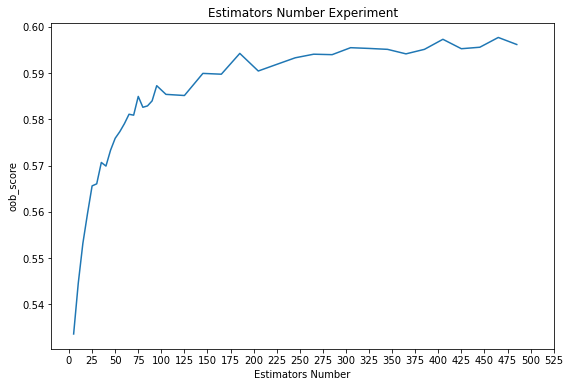

In [126]:
plt.figure(figsize=(9,6))
plt.title('Estimators Number Experiment')
plt.plot(n_estimators_experiment.index,n_estimators_experiment['oob_score'])
plt.xlabel('Estimators Number')
plt.ylabel('oob_score')
plt.xticks(np.arange(0,550,25))
plt.show()

### Значимость признаков

Обучим модель с 250 деревьями

In [76]:
rf_model = ensemble.RandomForestClassifier(n_estimators = 250,  oob_score=True)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=250, oob_score=True)

In [77]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [78]:
print(f'Training accuracy score is {accuracy_score(y_train,y_train_pred)}, F1-score is {f1_score(y_train,y_train_pred)}')
print(f'Testing accuracy score is {accuracy_score(y_test,y_test_pred)}, F1-score is {f1_score(y_test,y_test_pred)}')

Training accuracy score is 0.9997530162885757, F1-score is 0.9997523955728328
Testing accuracy score is 0.598369967893307, F1-score is 0.6022988505747128


In [160]:
importances = rf_model.feature_importances_
importances = rf_model.feature_importances_
indices = np.argsort(importances)[:-11:-1]

In [161]:
print("Feature ranking:")
for i in indices:
    print(f'feature {features[i]}: ({importances[i]})')

Feature ranking:
feature ltv: (0.11529064914601447)
feature disbursed_amount: (0.10856523997223494)
feature asset_cost: (0.10331785312273219)
feature Employee_code_ID: (0.09585436160856052)
feature supplier_id: (0.0917593710473723)
feature Date.of.Birth: (0.08508316879819029)
feature branch_id: (0.07070954748650789)
feature PERFORM_CNS.SCORE: (0.03437009669576087)
feature CREDIT.HISTORY.LENGTH: (0.02854804753613667)
feature manufacturer_id: (0.02696224917378047)


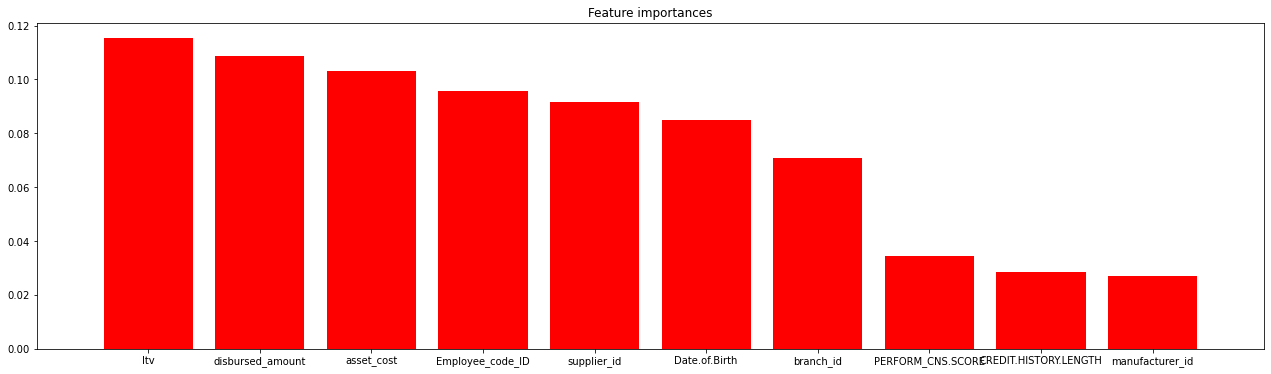

In [170]:
plt.figure(figsize=(22,6))
plt.title("Feature importances")
plt.bar(range(10), importances[indices], align = 'center', color = 'r')
plt.xticks(range(10), np.array(features)[indices])
plt.xlim([-1, 10])
plt.show()

Модель выделяет следющие важные признаки при принятии решения:
1. ltv - Отношение заёма к стоимости актива
1. disbursed_amount - Сумма выданного кредита
1. asset_cost - Стоимость актива
1. Employee_code_ID - ID сотрудника организации, зарегистрировавший выплату
1. supplier_id - Автосалон, у которого был выдан заем
1. Date.of.Birth - 	Дата рождения покупателя
1. branch_id - Филиал, в котором был выдан кредит

Интересно, что наряду со стоимостью актива и суммой выданного кредита, модель отметила важными признаки, относящие к информации о кредиторе и автосалоне. Хотя интуитивно кажется, что эта информация никак не должна влиять на результат модели

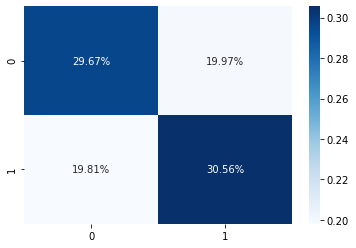

In [15]:
CF = confusion_matrix(y_test_pred, y_test)
sns.heatmap(CF/np.sum(CF), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

## Gradient Boosting

Пришло время градиентного бустинга 😎

Обучим модельки с разным числом деревьев

In [31]:
accuracy_train_dict = {}
accuracy_test_dict = {}

In [42]:
for n_estimators in tqdm(range(500,800,50)):
    rf_model = ensemble.AdaBoostClassifier(n_estimators=n_estimators)
    rf_model.fit(X_train, y_train)
    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)
    
    accuracy_train_dict2[n_estimators] = accuracy_score(y_train_pred, y_train)
    accuracy_test_dict2[n_estimators] = accuracy_score(y_test_pred, y_test)
    
dump(accuracy_train_dict2, 'accuracy_train_dict2.pickle')
dump(accuracy_test_dict2, 'accuracy_test_dict2.pickle')

100%|██████████| 6/6 [11:02<00:00, 110.43s/it]


In [43]:
accuracy_train_dict = merge_and_order(accuracy_train_dict2, accuracy_train_dict)
accuracy_test_dict = merge_and_order(accuracy_test_dict2, accuracy_test_dict)

In [44]:
n_estimators_experiment = pd.DataFrame.from_dict(accuracy_train_dict, orient='index', columns=['accuracy_train'])
n_estimators_experiment['accuracy_test'] = accuracy_test_dict.values()
n_estimators_experiment.to_csv('n_estimators_experiment_adaboost.csv')

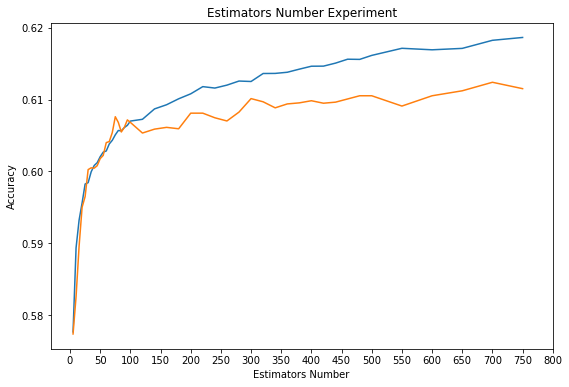

In [53]:
plt.figure(figsize=(9,6))
plt.title('Estimators Number Experiment')
plt.plot(n_estimators_experiment.index,n_estimators_experiment['accuracy_train'])
plt.plot(n_estimators_experiment.index,n_estimators_experiment['accuracy_test'])
plt.xlabel('Estimators Number')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,810,50))
plt.show()

In [54]:
n_estimators_experiment.max()

accuracy_train    0.618632
accuracy_test     0.612398
dtype: float64

In [55]:
n_estimators_experiment.min()

accuracy_train    0.577670
accuracy_test     0.577377
dtype: float64

В отличие от Random Forest, модель переобучается гораздо меньше, а тестовая accuracy даже немного больше. При этом, разброс accuracy на тестовой выборке больше, а на тренировочной - продолжает расти, хоть и доольно медленно

Обучим модель с 300 деревьями

In [59]:
rf_model = ensemble.AdaBoostClassifier(n_estimators = 300)
rf_model.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=300)

In [60]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [72]:
print(f'Training accuracy score is {accuracy_score(y_train,y_train_pred)}, F1-score is {f1_score(y_train,y_train_pred)}')

Training accuracy score is 0.612507255146523, F1-score is 0.6243055555555556


In [73]:
print(f'Testing accuracy score is {accuracy_score(y_test,y_test_pred)}, F1-score is {f1_score(y_test,y_test_pred)}')

Testing accuracy score is 0.6101259570264262, F1-score is 0.6262607131019461


In [62]:
importances = rf_model.feature_importances_
importances = rf_model.feature_importances_
indices = np.argsort(importances)[:-11:-1]

In [63]:
print("Feature ranking:")
for i in indices:
    print(f'feature {features[i]}: ({importances[i]})')

Feature ranking:
feature branch_id: (0.27666666666666667)
feature supplier_id: (0.09333333333333334)
feature ltv: (0.07)
feature PERFORM_CNS.SCORE: (0.07)
feature disbursed_amount: (0.05333333333333334)
feature Employee_code_ID: (0.05)
feature Date.of.Birth: (0.04)
feature PRI.CURRENT.BALANCE: (0.03666666666666667)
feature PRI.ACTIVE.ACCTS: (0.03)
feature asset_cost: (0.023333333333333334)


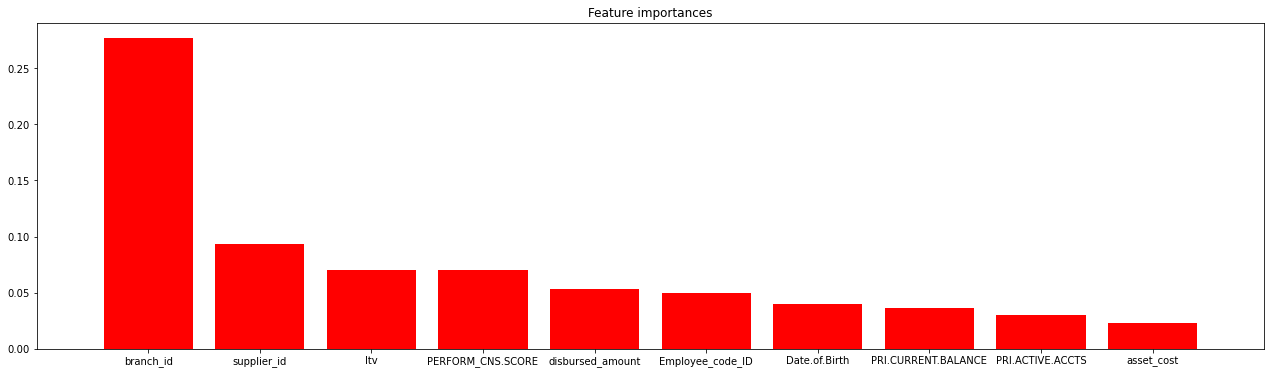

In [64]:
plt.figure(figsize=(22,6))
plt.title("Feature importances")
plt.bar(range(10), importances[indices], align = 'center', color = 'r')
plt.xticks(range(10), np.array(features)[indices])
plt.xlim([-1, 10])
plt.show()

Теперь самый главный признак - это branch_id - филиал, в котором был выдан кредит.  Кажется модель что-то знает про автомобильный бизнес 😁

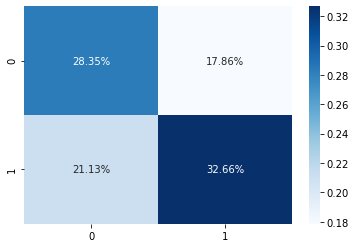

In [75]:
CF = confusion_matrix(y_test_pred, y_test)
sns.heatmap(CF/np.sum(CF), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

## Вывод

В сравнении с предедущими методами классификации (kNN, SVM и нейроночки) градиентный бустинг показал самый лучший (хотя по-прежнему довольно скромный) результат: примерно 61% точности. 

Несмотря на большое количество признаков, они несут мало полезной информации для модели, а представляют собой лишь описание и сопутствующие данный той или иной кредитной сделки